# `AA` - Workshop 6

In this workshop we will dive into classification. Classification is the prediction of classes. This means our target variable can take only a set of discrete values (versus the continuous case for regresssion). 

We will cover the following: 
1. Linear Classification
1. Non-Linear Classification

Whereas our previous introduction to machine learning focused on the case of predicting real-valued outputs (called the regression setting), these notes consider the case of predicting discrete-valued outputs. This is called the classification setting. And while it may seem as though this would require very different techniques to handle (after all, the regression setting we just considered made very "continuous" predictions rather than discrete ones), one nice thing about our generic framework for machine learning is that in reality, there is very little difference between how we handle regression and classification problems. Like before, there are hypothesis functions, loss functions, and our goal is still to solve the canonical problem of minimizing the sum of losses on a data set (the only real difference is in the choice of loss function, as we will see even the hypothesis class largely remains the same).



## `Linear Classification`

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

Let us first consider a very simple illustrative example...

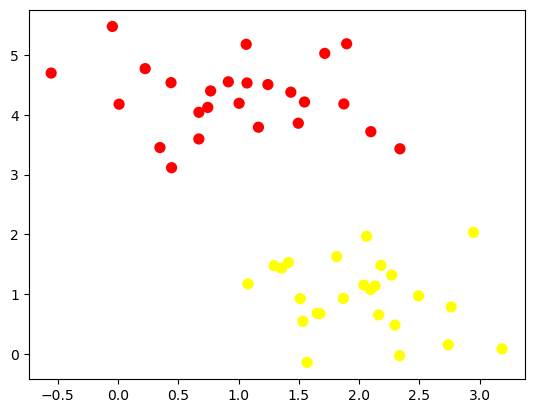

In [4]:
# make_blobs is a sample generator that generates isotropic Gaussian blobs for clustering
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

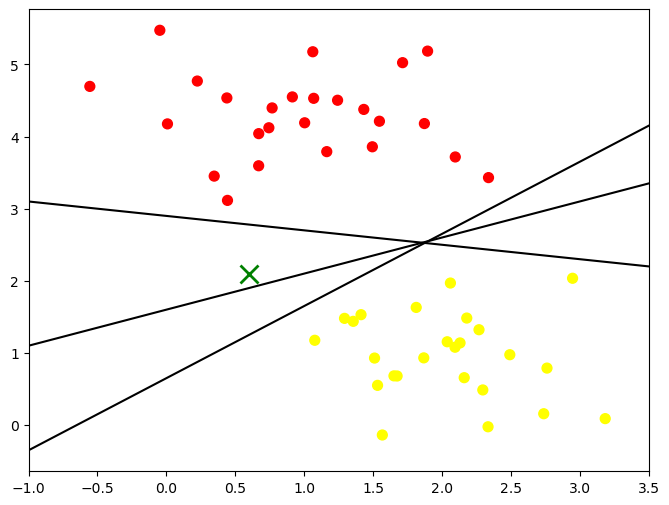

In [5]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='green', markeredgewidth=2, markersize=13)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Example: breast cancer classification

As an example to introduce classification problem, we're going to turn to a classical example from the machine learning literature, first presented in [[Street et al, 1993]](http://ftp.cs.wisc.edu/math-prog/tech-reports/olm102.ps) of identifying whether cancer cells from a biospy are malignant or benign.  This was historically an important data set in the intersection of machine learning and health care, and similar subjects are still a topic of very active research.  Of course, 25 years ago, the techniques were much more primitive and computationally less intense than current approaches to similar problems, but the work has become a classical data set in machine learning, and also represent a compelling applications.

To create the data set, researchers took 569 images of cancerous cells, under a microscope, and manually selected the outlines of the different cells (this step is the kind of thing that would ideally be replaced by automatic computer vision architectures in current systems).  The resulting figures looked like this:

<img src="cancercells.png" width="450"/>

The researchers then considered 10 different features of each cell, of instance the area, perimeter, texture, number of concave points (i.e., indentations), variance of grayscale color, and some others (a full list is in the above paper).  For each of these 10 features they computed the mean, max, and standard deviation of the feature across all the cells in the image, resulting in a 30 dimensional vector describing each sample.

The following is a plot of two of these features (mean # of concave points, and mean area) for all examples in the data set; blue points denotes a benign tumor, whereas red points denote a malignant tumor.  (Note that the dataset is so common, it's included in the actual scikit-learn package itself).

In [6]:
cancer_df = pd.read_csv("breast_cancer.csv", index_col = "id")
cancer_df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


Let us plot `area_mean` vs. `concave points_mean` and see how the results differ for **malignant** and **benign** tumors:

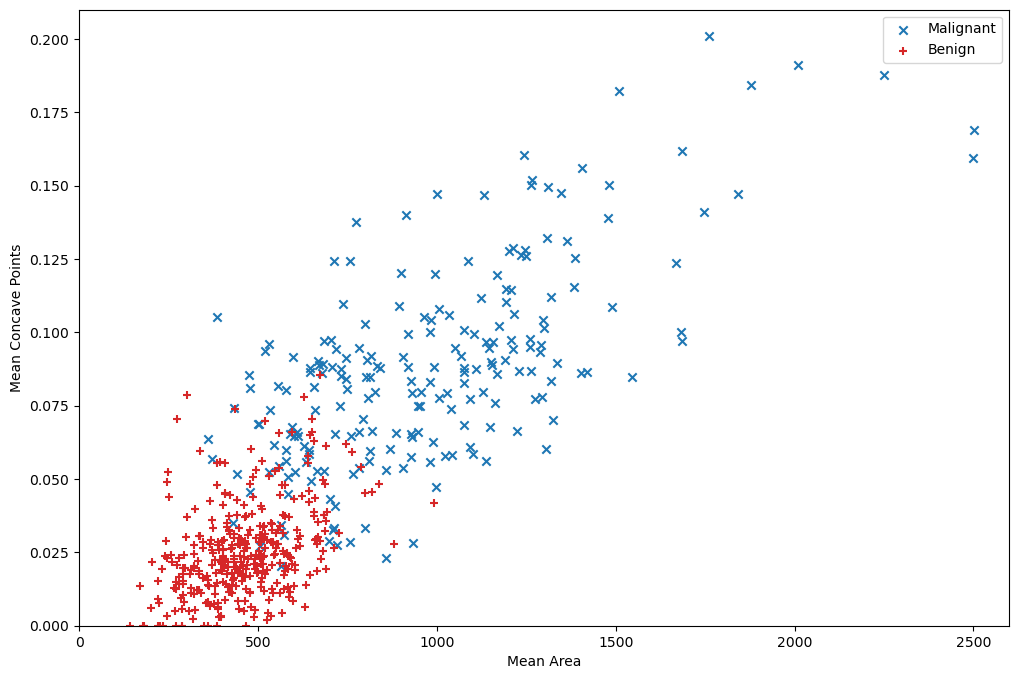

In [7]:
def plot_cells():
    plt.figure(figsize=(12,8))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Malignant', 'Benign'])
    
plot_cells()

There is obviously some structure to the data here: cells with greater average area and greater numbers of concave points are more likely to be malignant. And whereas your mental model of simple linear regression should be something like "fitting a line to the data", your mental model of a classification task should be "separating the classes with a line". Something like the following (just a hand-picked example of a line, we will shortly see how to actually fit these to the data, much like we did for regression).

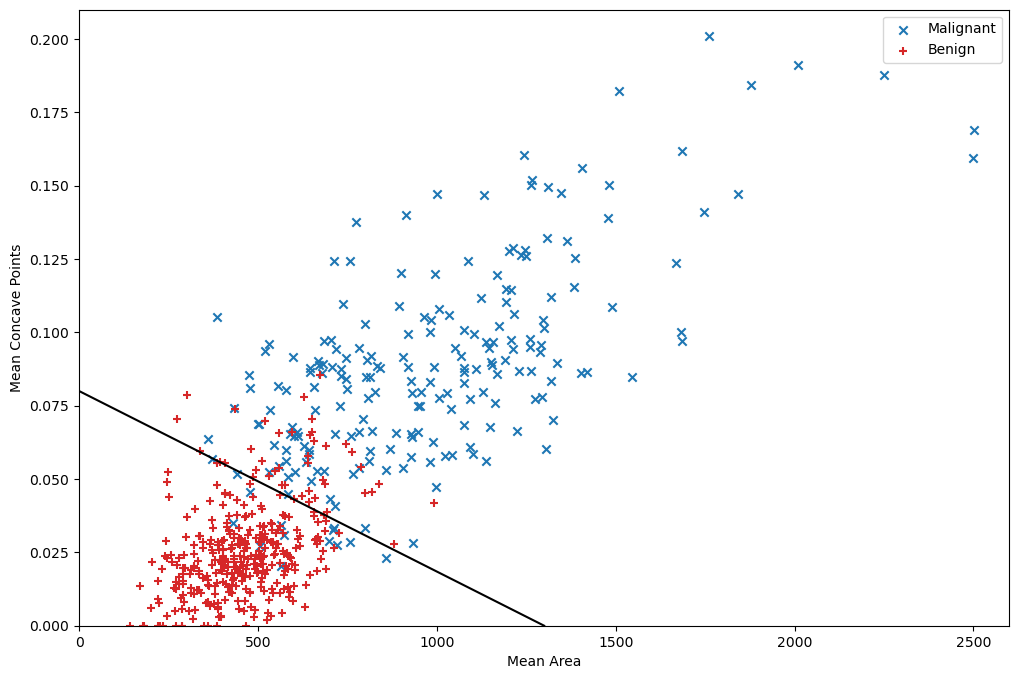

In [8]:
plot_cells()
plt.plot([0, 1300], [0.08,0], 'k-') # we manually fit a line here by defining the intercepts with the x- and y-axis
plt.show()

Just as our linear regression line did not pass exactly through all the data points, we can't achieve here a line that exactly separates all the data points. But there is clearly as sense in which points below the line are "more likely" to be benign, and above the line are "more likely" to be malignant. 

### Alternative losses for classification

Given the difficulties of minimizing sum of zero-one losses, one typically uses an alternative loss in classification.  There are many such losses, and different choices here lead to different machine learning algorithms (often with very little indication that all that differs between the algorithm is in fact the choice of loss function).  Let's consider a few of of the more common ones:

- **Logistic loss:** $\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))$  <br/> For large positive values of $h_\theta(x) \cdot y$, $\exp(-h_\theta(x) \cdot y)$ will be very close to zero, so the loss will approach zero; for large negative values $\log(1+\exp(-h_\theta(x) \cdot y)) \approx -h_\theta(x) \cdot y$ so the loss increases approximately linearly.
- **Hinge loss:** $\ell_{\mathrm{hinge}}(h_\theta(x), y) = \max\{1 - h_\theta(x) \cdot y, 0\}$ <br/>  As long as $h_\theta(x) \cdot y \geq 1$, this loss will be zero, whereas it will increase linearly for negative $h_\theta(x) \cdot y \geq 1$.
- **Exponential loss:** $\ell_{\mathrm{exp}}(h_\theta(x), y) = \exp(-h_\theta(x) \cdot y)$ <br/> For a similar reason as with logistic loss, this loss will go to zero for large $h_\theta(x) \cdot y$; but for negative $h_\theta(x) \cdot y$ the loss increases very quickly.



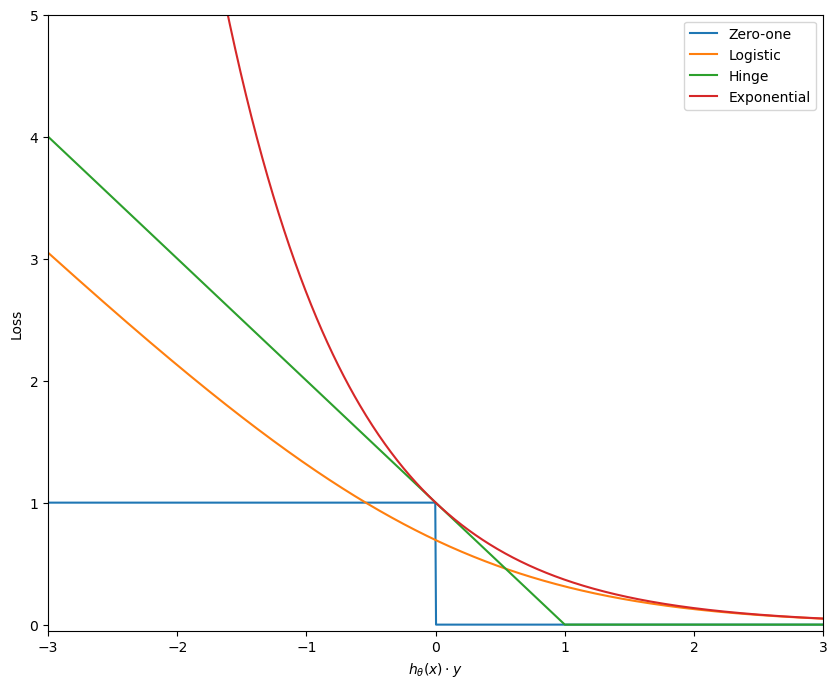

In [9]:
hy = np.linspace(-3,3,1000)
plt.figure(figsize = (10,8))
plt.plot(hy,(hy<=0))
plt.plot(hy, np.log(1+np.exp(-hy)))
plt.plot(hy, np.maximum(1 - hy, 0))
plt.plot(hy, np.exp(-hy))
plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")
plt.legend(['Zero-one', 'Logistic', 'Hinge', 'Exponential'])
plt.show()

## Solving classification tasks

With this framework and set of loss functions laid out, the task of learning a classifier is exactly the same as the regression methods we considered previously.  That is, given a data set we seek to minimize the average loss
\begin{equation}
\min_{\theta} \frac{1}{m}\sum_{i=1}^{m} \ell(h_{\theta}(x^{(i)}),y^{(i)})
\end{equation}

Unlike regression, there is virtually no setting (except, of course, just using least-squares loss) where there is an analytical solution to this optimization problem.  Nonetheless, we can still solve it by resorting back to gradient descent (there are alternative optimization approaches for most of these problems, but we'll only cover gradient descent).  To see how this works, we'll next consider some collection of specific machine learning algorithms that result in specific choices of loss function.




### `Support vector machine classification`

Support vector machines (SVMs) result from choosing hinge loss
\begin{equation}
\ell_{\mathrm{hinge}}(h_\theta(x),y) = \max \{1-h_\theta(x)\cdot y, 0\}
\end{equation}
as the loss function to minimize.  If you have seen support vector machines before, you may have seen them explained in a geometric context, illustrating that they maximize the "margin" of separation between examples of different classes.  This is true, and support vector machines absolutely can be viewed this way.  But it is also instructive to simply understand them as minimizing the particular loss function above.

Support vector machines also refer either to a linear hypothesis function, or a particular form of nonlinear hypothesis known as a _kernel_ hypothesis; if you ever hear the terms "linear SVM" or "kernel SVM", this is just the designation of which type of hypothesis function they are using.  That is, linear SVMs use the hypothesis function
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x,
\end{equation}


**SVM Inutition: Maximizing the Margin**

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

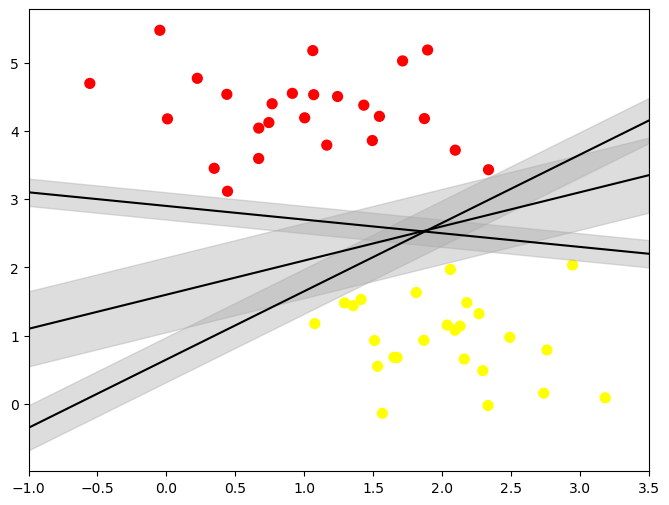

In [10]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on breast cancer data.

The scikit-learn library, which we previously discussed in the context of regression, also has built-in algorithms for classification.  Using these again just requires the initialization, `.fit()`, and `.predict()` methods, with the additional note that if you want the actual output of the hypothesis function, you need to use the `.decision_function()` call.

There is also a `LinearSVC` class which uses a slightly different algorithm, but which is largely similar.  Note that this class by default uses the squared hinge loss rather than the hinge, so we need to specify `loss='hinge'` if we want the normal hinge. 

We also consider here the scikit-learn way of normalizing features.  This is done via the `sklearn.preprocessing.StandardScalar` class.  These have a similar interface as the machine learning classes, with a similar method `.fit()` (which computes the mean and variance of a column), and `.transform()` (which converts the data to have zero mean and unit variance).  Let's see how this class works.

In [11]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

We again normlize our features using the StandarScaler class in scikit learn.

In [12]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

**Recall**: StandardScaler normalizes to 0 mean and unit variance

In [13]:
print("Mean and standard deviation of Non-normalized X: ", np.mean(X, axis=0), np.std(X, axis=0))
print("Mean and standard deviation of normalized X: ", np.mean(X_norm, axis=0),np.std(X_norm, axis=0))

Mean and standard deviation of Non-normalized X:  [6.54889104e+02 4.89191459e-02] [3.51604754e+02 3.87687325e-02]
Mean and standard deviation of normalized X:  [-2.18532476e-16 -4.99502802e-17] [1. 1.]


In [14]:
from sklearn.svm import LinearSVC # Linear Support Vector Classifier

model_SVM = LinearSVC(loss='hinge')
model_SVM.fit(X_norm, Y)  # Note: There is no need to encode Y. The algorithm does that automatically

LinearSVC(loss='hinge')

In [15]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),  # create coordinate mesh
                        np.linspace(y_range[0], y_range[1], grid))
    
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant', 'Benign'])

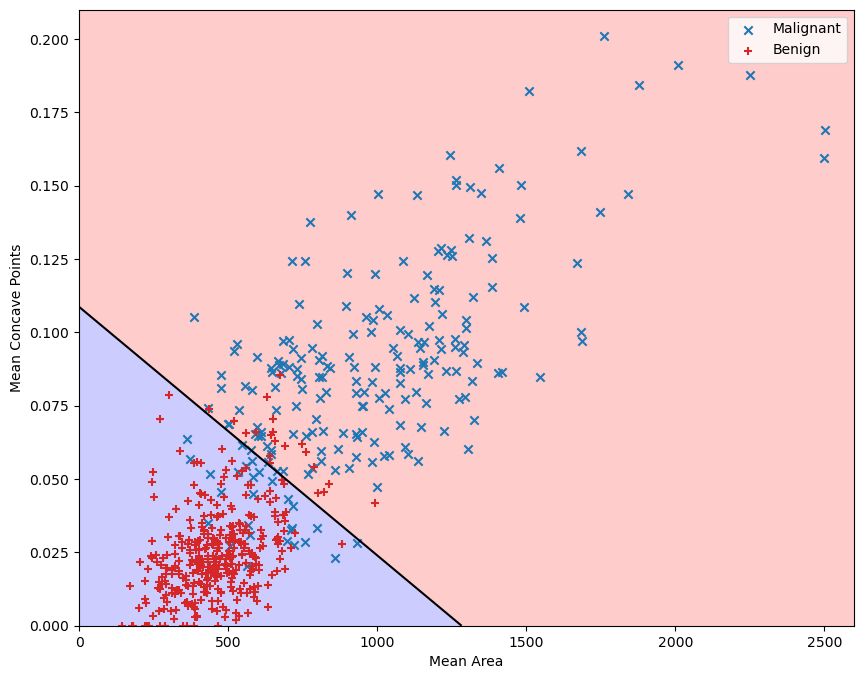

In [17]:
plot_classification_sklearn(model_SVM, norm)

How well does SVM Classification perform? Let us look at accuracy.

In [16]:
(model_SVM.predict(X_norm) == Y).mean()  # Note: mean() operation on booleans returns the proportion of True

0.9173989455184535

Scikit-learn also provides a shorthand metric function for this: `accuracy_score`

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(Y, model_SVM.predict(X_norm))

0.9173989455184535

# `Non-Linear Classification`

Just like for linear vs. non-linear regression, the application to the classification setting is just a matter of plugging in the relevant features into our classification algorithms.  Here we won't bother with implementing the algorithms again manually. Instead, we'll use the scikit learn implementations of the support vector machine with explicit nonlinear features, to visualize the kind of decision functions that result from the inclusion of nonlinear features in classification.

Let's begin by considering again our example of the breast cancer cell classification task, loading the data and running a linear SVM on the two-feature reduced example. Note how we already use the polynomial features method for that, using degree one.


In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [33]:
from sklearn.svm import LinearSVC # Linear Support Vector Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [34]:
norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

In [35]:
def poly_feat_sklearn (X, deg):
    model = PolynomialFeatures(deg)
    X = model.fit_transform(X)
    return X

In [36]:
def plot_classification_sklearn_non_lin(model, norm, deg):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))  # create coordinate mesh
    
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(poly_feat_sklearn(norm.transform(X_),deg)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant','Benign'])

0.9156414762741653


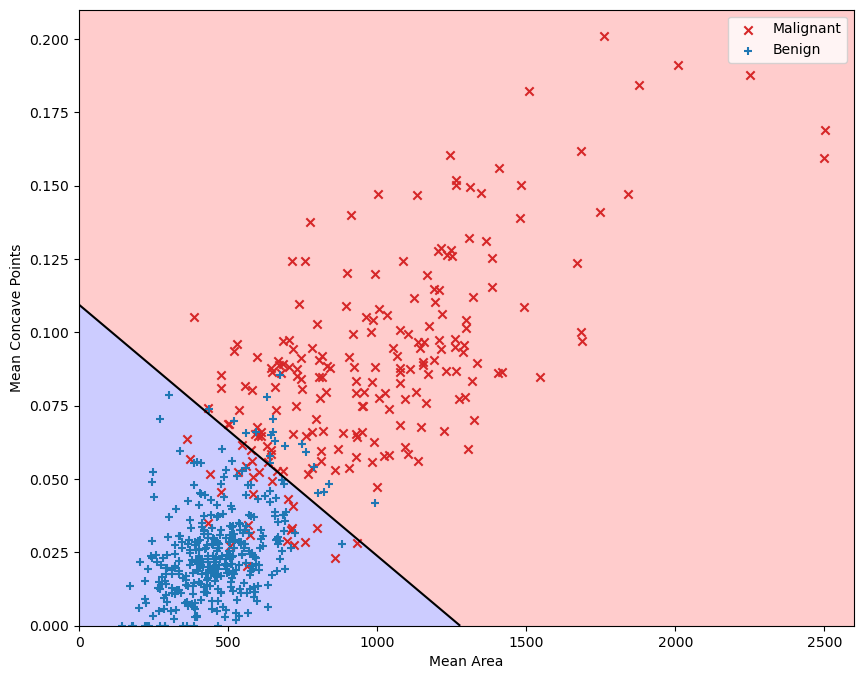

In [37]:
deg=1
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9103690685413005


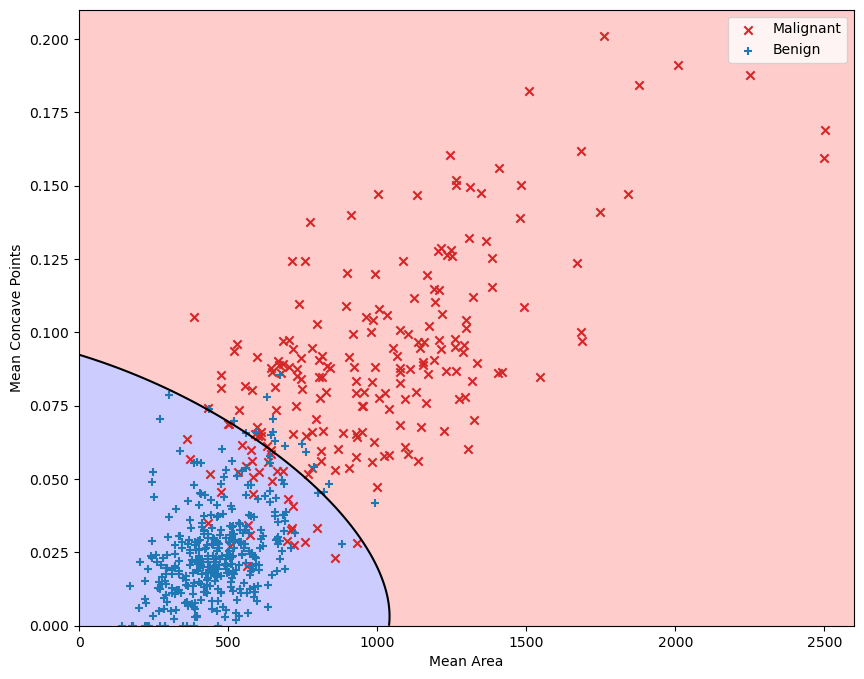

In [38]:
deg=2
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9173989455184535


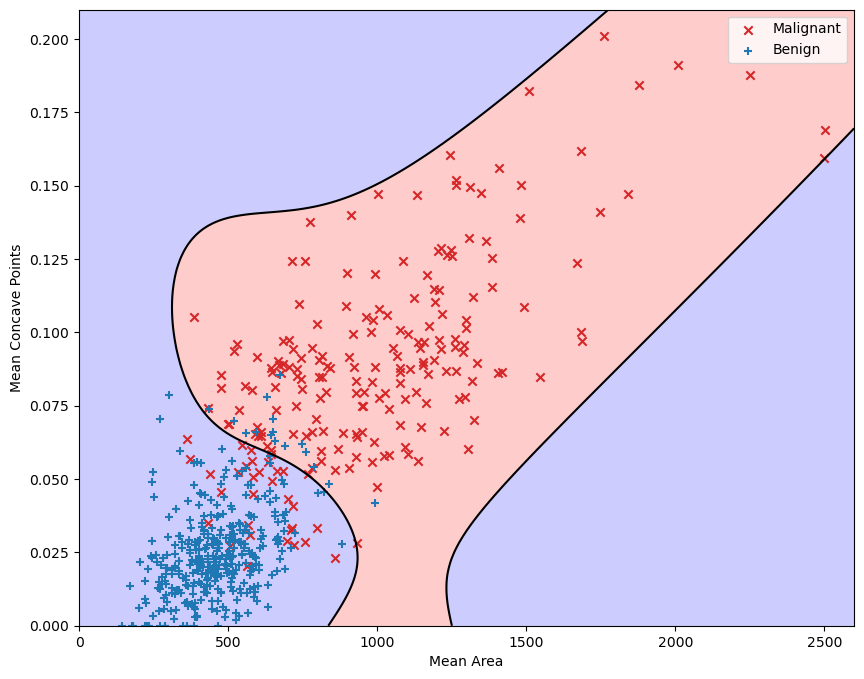

In [39]:
deg=4
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9156414762741653


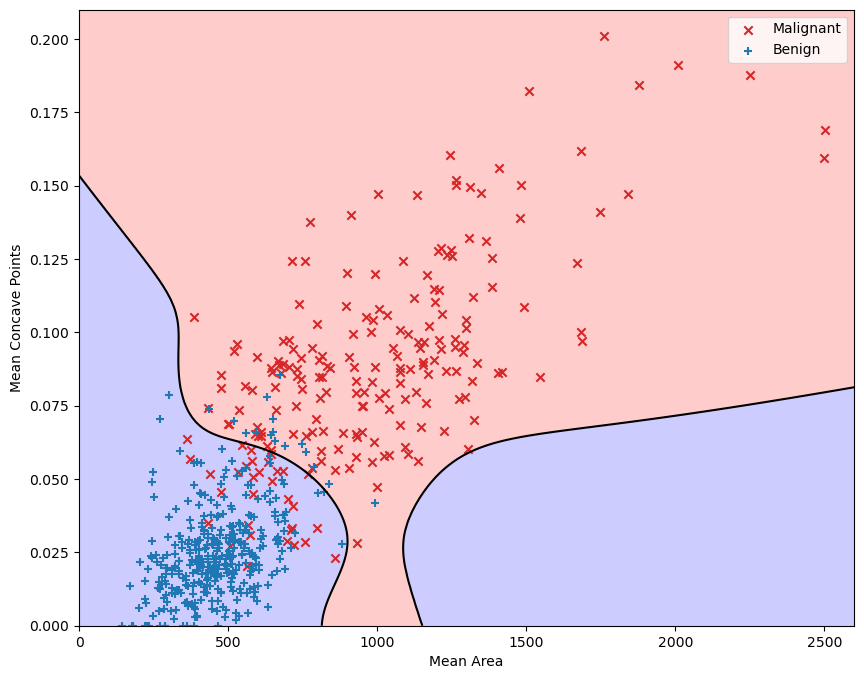

In [40]:
deg=8
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

At this point, just like with the regression examples we saw, the model is probably starting to overfit.  And just like before, we can counteract this to some extent by increasing the regularization parameters (or in scikit learn's terminology, decreasing the $C$ parameter).

0.9103690685413005


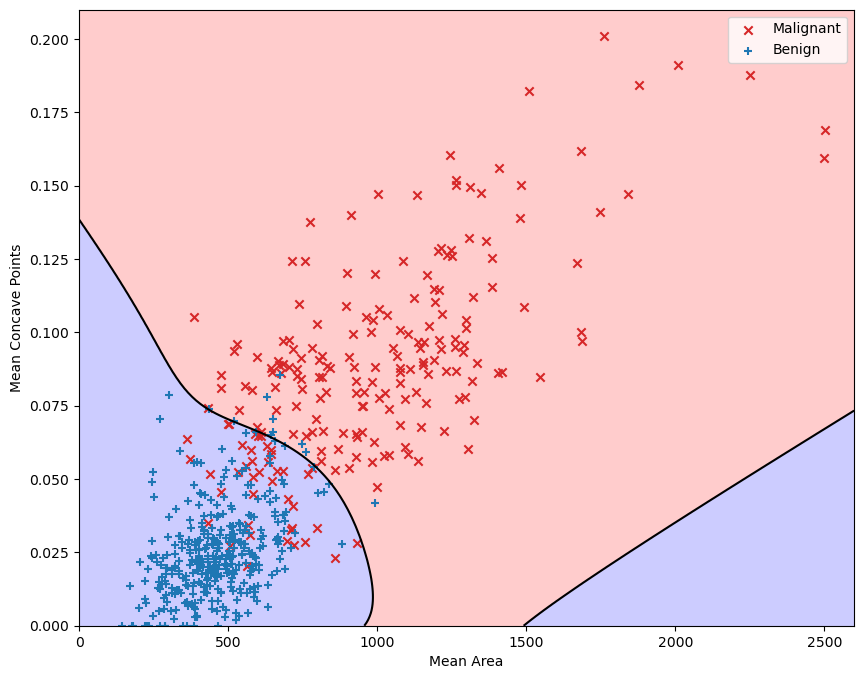

In [41]:
deg=8
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000, C=0.1)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

Scikit-Learn actually contains a more general implementattion of SVM classification, which allows us to freely use other types of feature relationships, employing a so called kernel (linear, RBF, poly, etc.). Let's have a look and let us consider some kernel-based functions. Note that in addition to adding the `degree=d` parameter, you'll want to set the `coef0=1.0` parameter to include the constant term `1` in the kernel function (without this, the polynomial kernel only has terms of degree _exactly_ $d$, and typically performs quite poorly.

## `Polynomial Kernel`

In [42]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')
    
    # plot data points
    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant','Benign'])

0.9121265377855887


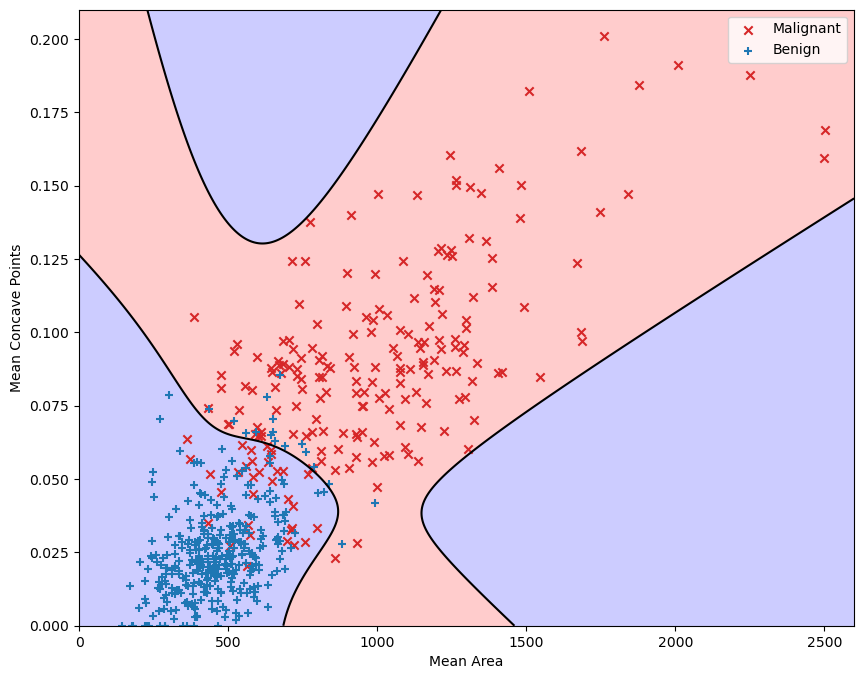

In [62]:
from sklearn.svm import SVC

deg=4
model = SVC(kernel='poly', C=100, degree=deg, coef0=1.0)
model.fit(X_norm, Y)
plot_classification_sklearn(model, norm)
print(accuracy_score(Y,model.predict(X_norm)))

Note that this returns approximately the same result as our manually defined linear SVM with polynomial features. 
This is a good sanity check!

0.9138840070298769


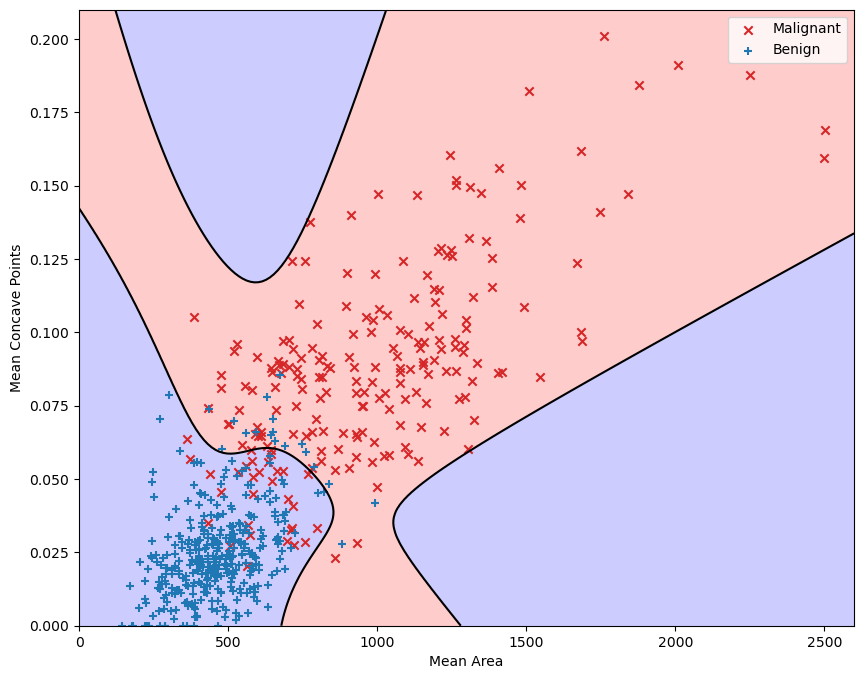

In [64]:
deg=4
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge', max_iter = 100_000, C=100)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

## `Radial basis functions`

Considering an anecdotal estimate, probably the most frequently used type of nonlinear feature in not the polynomial, but something called the _radial basis function_ , often abreviated as RBF.  Radial basis functions are similar to polynomials in that they are non-linear functions of the input data, but they are notably different in that they are generally _local_ features: the value of any particular feature is close to zero for most of the input space, but non-zero in a small region around a "center" parameter.  Let's start with the definition, and we can then provide some illustrations that hopefully make this more concrete.  To keep this simple to start, we're only going to consider radial basis functions of one-dimensional raw inputs, though it can be expanded for a general $n$-dimensional case.  A radial basis function feature vector is defined as the following:
\begin{equation}
\phi : \mathbb{R} \rightarrow \mathbb{R}^k = \left [ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu_{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right ]
\end{equation}
where $\mu^{(1)},\ldots,\mu^{(k-1)} \in \mathbb{R}$ (called the means) and $\sigma \in \mathbb{R}$ (called the bandwidth) are the hyperparameters of this feature vector.  

Let's look at a single one of these terms $\phi_j(x)$ (this is the $j$th element of the feature vector, because remember $\phi(x)$ outputs a $k$-dimensional vector.
\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}
If you're familiar with the Gaussian distribution, you may recognize this as looking similar to the density function of the Gaussian (though without the normalizeng constant).  One single dimension of this feature (for varying inputs $x$, and here assuming mean $\mu^{(j)} = 1.5$ and $\sigma = 0.4$) looks like the following:

Text(0, 0.5, '$\\phi_j(x)$')

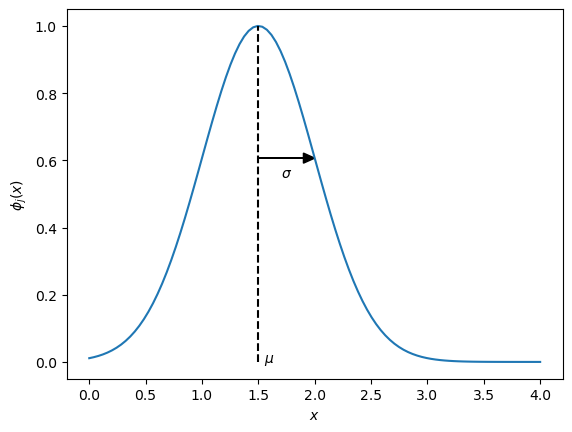

In [65]:
x = np.linspace(0,4,100)
mu_j = 1.5
sigma = 0.5
plt.plot(x,np.exp(-(x-mu_j)**2 / (2*sigma**2)))
plt.plot([1.5,1.5], [0,1], 'k--')
plt.text(1.55, 0, r"$\mu$")
plt.arrow(1.5, np.exp(-0.5), 0.5-0.1, 0, head_width=0.03, head_length=0.1, fc='k')
plt.text(1.7, 0.55, r"$\sigma$")
plt.xlabel("$x$")
plt.ylabel(r"$\phi_j(x)$")

The feauture is largest (equal to one) when $x$ is equal to $\mu$, but falls of very rapidly as $x$ moves away from $\mu$ (proportional to the exponential of the negative squared difference, which will go effectively zero very quickly).  Those who are familiar with Gaussian densities will notice the familiar formula and bell-shaped curve, where about two thirds of the area under the curve lies within $\sigma$ of the center.  Note however, that despite superficial similarities, this is _not_ a Gaussian distribution: it is not scaled, and the maximum value for any specific feature is always 1.0 for $x = \mu_j$.  To emphasize this difference further, some definitions of RBFs define them just in terms of a different scaling parameter instead of the bandwidth
\begin{equation}
\phi_j(x) = \exp(-\gamma (x-\mu^{(j)})^2)
\end{equation}
which of course is equivalent to the above if we set $\gamma = 1/(2\sigma^2)$.  However, it's a bit more common to see the bandwidth parameter formulation, just because it _does_ let you use the general intuition about the size of a bell curve that many people have from using Gaussian distributions.

To get some intuition about how these RBFs work as features, consider a feature vector with $k=10$ (i.e., 9 RBF features plus a constant term), with $\mu^{(j)} = 0,0.5,1.0,\ldots,4.0$ and $\sigma=0.5$.  The set of all basis functions looks like the following.

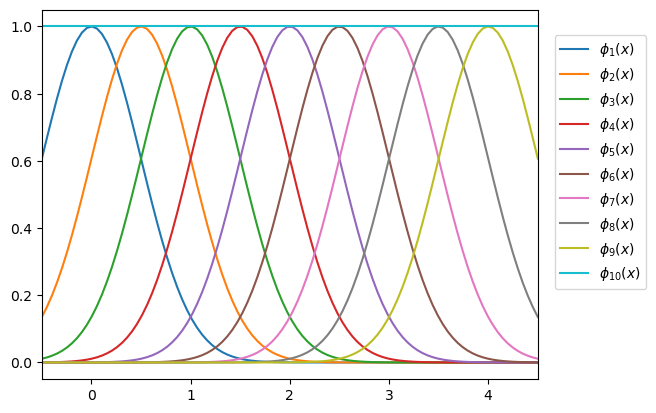

In [66]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0,4,9)
sigma = 0.5
for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))

In two-dimension space this looks like a mountain-range (when you use hiking maps with contour lines) from above:

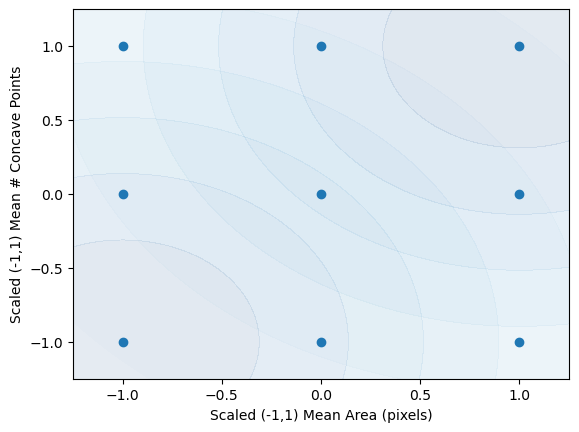

In [68]:
d = 3
sig = d/2

fig, ax = plt.subplots()

XY = np.meshgrid(np.linspace(-1,1,d), np.linspace(-1,1,d))
mu = np.array([XY[0].ravel(), XY[1].ravel()]).T

XX,YY = np.meshgrid(np.linspace(-1.25,1.25,100), np.linspace(-1.25,1.25,100))
# sig = 0.25
for mu_ in [mu[0], mu[-1]]: # we only visualize the top-right and bottom-left for visibility
    ZZ = np.exp(-((XX-mu_[0])**2 + (YY-mu_[1])**2)/(2*sig**2))
    plt.contourf(XX,YY,ZZ, alpha=.1, cmap='Blues')
plt.scatter(mu[:,0], mu[:,1])

ax.set_ylabel('Scaled (-1,1) Mean # Concave Points')
ax.set_xlabel('Scaled (-1,1) Mean Area (pixels)')
plt.show()

The goal of nonlinear fitting with RBFs is to approximate the underlying function with a linear combination of these features.  By combining them in the proper manner, it is possible to approximate very general functions.

Note also that there is no need to normalize the data, because the RBF features will always be scaled to be between zero and one (we could further normalize the generated features themselves, but this is typically not needed, as the features by definition will already be scaled to the range $[0,1]$).

0.9156414762741653


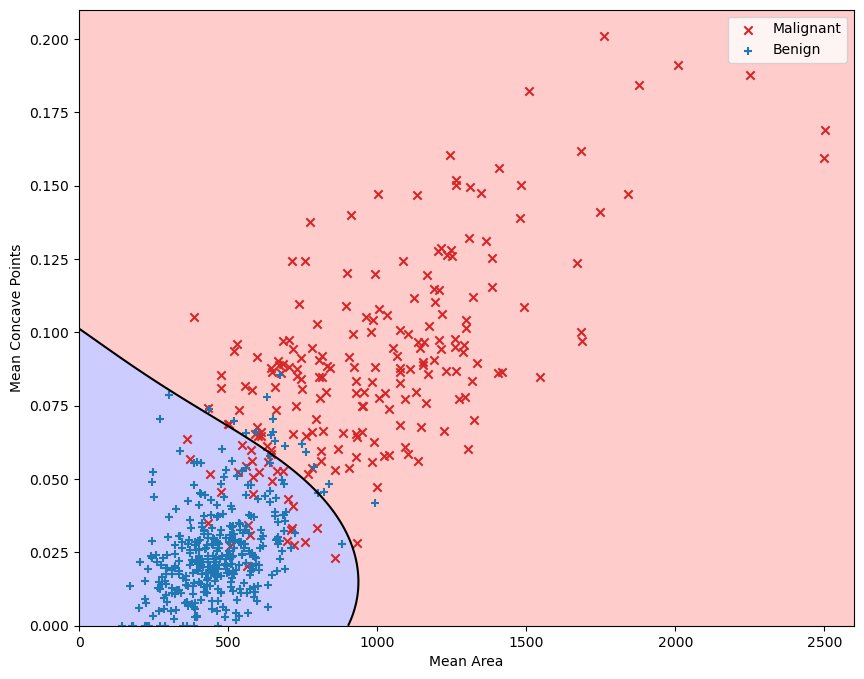

In [69]:
gamma = 1 / (len(X_norm) * X_norm.var()) # scikit-learn uses gamma = 1/(n_features*X.var()) parameterization
model_rbf = SVC(kernel='rbf', C=10.0, gamma=100*gamma)
model_rbf.fit(X_norm, Y)
plot_classification_sklearn(model_rbf, norm)
print(accuracy_score(Y,model_rbf.predict(X_norm)))

And finally, because all these example admittedly look fairly similar (the decision boundary _is_ roughly linear with some noise, after all), let's consider a case where we make the bandwidth small enough so that the method is guaranteed overfit to the training data.  Here we make the bandwidth very small (i.e. $\gamma$ large), and the regularization small, so that the classifier actually managed to get 100% accuracy on the training data (of course with very poor generalization performance.

0.9929701230228472


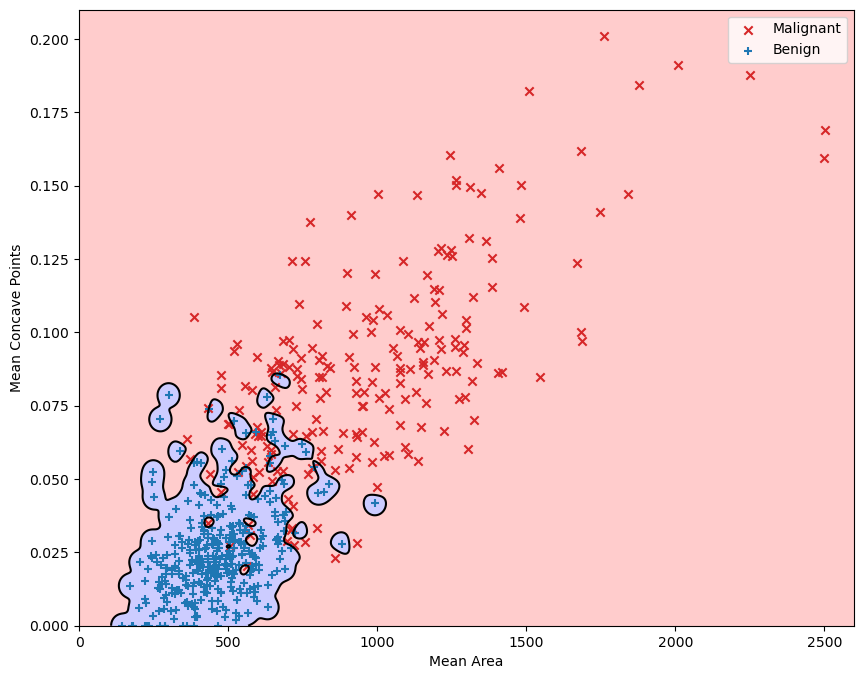

In [70]:
gamma = 1 / (len(X_norm) * X_norm.var()) # scikit-learn uses gamma = 1/(n_features*X.var()) parameterization
model_rbf = SVC(kernel='rbf', C=10.0, gamma=100000*gamma)
model_rbf.fit(X_norm, Y)
plot_classification_sklearn(model_rbf, norm)
print(accuracy_score(Y,model_rbf.predict(X_norm)))

The important thing to keep in mind through all this is how the nonlinear features and hyperparameter settings will influence the ability of functions to represent complex data and to overfit and underfit the data.  And of course, when using scikit learn, you'll need to understand the documentation to the point where you see how the hyperparameters of the class of interest map to the parameters that you actually want to control.  This usually requires going through the documentation a fair amount, but it's quite important, and the default parameters are often quite poor.

---

**End of workshop task**: The above exercises have been exclusively designed to illustrate the workings of relevant classification algorithms. One issue with that is that we have trained our algorithms on the full set of available data. The classification metrics are therefore relatively meaningless as wee need to evaluate on previously unseen data. Design a proper model development routine to train a high-performing classification algorithm for the breastcancer dataset. Proceed as follows:

1. Define your feature and target sets
1. Partition the data into training, validation and test set
1. Optionally scale your data.
1. Decide on the type of algorithm you want to use
1. Train the algorithm on the training set
1. Tweak hyper parameters by validating on the validation set
1. Report test metrics from the unseen test set
1. Plot training, validation and test set classification results! (It might be wise to do it in seperate plots)

In [1]:
# YOUR CODE HERE

---